# Research Assistant Agent

The goal of this notebook is to build a lightweight, multi-agent system around LLM that customizes the research process. It has the following features:

1. **Source Selection:** Users can choose any set of input sources for their research.
2. **Planning:** Users provide a topic, and the system generates a team of AI analyst, each focusing on one sub-topic. `Human-in-the-loop` is used to refine the sub-topics before research begins.
3. **LLM Utilization:** Each analyst will conduct in-depth interviews with an expert AI using the selected sources. The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/pdf/2402.14207) paper using `Sub-Graph`
4. **Research Process:** Expers will gather information to answer analyst questions in `parallel` using `Map-Reduce` technique for efficiency.
5. **Output Format:** The gathered insights from each interview will be synthesized into a flexible output format using customizable prompts.

In [1]:
# Import libraries
import sys, os
import operator
from pprint import pprint
from typing import Any, List, Annotated
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display

from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import get_buffer_string
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
# Import settings and sensitive variables from config
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from codes.config.config import config

# Set langsmith project
os.environ["LANGSMITH_API_KEY"] = config.langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "storm-research-assistant"

2025-09-13 13:58:51,140 - root - INFO - Configuration loaded for environment: development


In [3]:
# Create llm
llm = ChatGoogleGenerativeAI(
    model=config.model.model_name, 
    api_key=config.model.api_key
)

# Analyst
Create analyst and review them using human-in-the-loop.

In [4]:
# States and Schemas
class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst."
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic."
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motivations."
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class CreateAnalystOutput(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations."
    )

class GenerateAnalystsState(TypedDict):
    topic: str  # Research topic
    max_analysts: int  # Number of analysts
    human_analyst_feedback: str  # Human feedback
    analysts: List[Analyst]  # Analyst asking questions

In [5]:
# Prompt
analyst_instructions_prompt = PromptTemplate(
    input_variables=["topic", "human_analyst_feedback", "max_analysts"],
    template="""You are tasked with creating a set of analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:   
{human_analyst_feedback}
    
3. Determine the most interesting anlyst with different perspectives analyzing the topic based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""
)

In [6]:
# Node
def create_analysts(state: GenerateAnalystsState):
    """Create analysts"""
    topic = state["topic"]
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    structured_llm = llm.with_structured_output(CreateAnalystOutput)

    # System message
    system_message = analyst_instructions_prompt.format(
        topic=topic, 
        human_analyst_feedback=human_analyst_feedback, 
        max_analysts=max_analysts
    )

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}


def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass


def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

2025-09-13 13:58:55,033 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-09-13 13:58:55,271 - urllib3.connectionpool - DEBUG - https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWNyZWF0ZV9hbmFseXN0cyhjcmVhdGVfYW5hbHlzdHMpCglodW1hbl9mZWVkYmFjayhodW1hbl9mZWVkYmFjazxoci8+PHNtYWxsPjxlbT5fX2ludGVycnVwdCA9IGJlZm9yZTwvZW0+PC9zbWFsbD4pCglfX2VuZF9fKFs8cD5fX2VuZF9fPC9wPl0pOjo6bGFzdAoJX19zdGFydF9fIC0tPiBjcmVhdGVfYW5hbHlzdHM7CgljcmVhdGVfYW5hbHlzdHMgLS0+IGh1bWFuX2ZlZWRiYWNrOwoJaHVtYW5fZmVlZGJhY2sgLS4tPiBfX2VuZF9fOwoJaHVtYW5fZmVlZGJhY2sgLS4tPiBjcmVhdGVfYW5hbHlzdHM7CgljbGFzc0RlZiBkZWZhdWx0IGZpbGw6I2YyZjBmZixsaW5lLWhlaWdodDoxLjIKCWNsYXNzRGVmIGZpcnN0IGZpbGwtb3BhY2l0eTowCgljbGFzc0RlZiBsYXN0IGZpbGw6I2JmYjZmYwo=?type=png&bgColor=!white HTTP/1.1" 200 12967


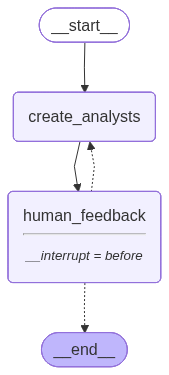

In [7]:
# Graph
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [8]:
# Input
max_analysts = 3 
topic = "Why python is the best language for AI development?"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

2025-09-13 13:58:56,422 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): api.smith.langchain.com:443
2025-09-13 13:58:56,772 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "GET /info HTTP/1.1" 200 773
2025-09-13 13:58:56,775 - langsmith.client - DEBUG - Tracing control thread func compress parallel called
2025-09-13 13:58:56,828 - langsmith.client - DEBUG - Sending multipart request to https://api.smith.langchain.com with context: trace=e16760af-2ee1-43b7-a121-c6116b24a4bc,id=e16760af-2ee1-43b7-a121-c6116b24a4bc; trace=e16760af-2ee1-43b7-a121-c6116b24a4bc,id=a1a7aed9-f4c0-4c73-9219-b0905516af8f; trace=e16760af-2ee1-43b7-a121-c6116b24a4bc,id=b9e3c4b2-863d-4190-ba73-467ad5fda3c9; trace=e16760af-2ee1-43b7-a121-c6116b24a4bc,id=20124175-4340-4717-b973-dd4729a7bac4
2025-09-13 13:58:57,038 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34


Name: Dr. Anya Sharma
Affiliation: Google AI Research
Role: AI Research Scientist
Description: Focuses on the breadth and depth of Python's AI/ML libraries and frameworks (e.g., TensorFlow, PyTorch, Scikit-learn, NumPy, Pandas), evaluating their capabilities, performance, and how they empower complex AI model development and scientific computing.
--------------------------------------------------
Name: Mark Chen
Affiliation: DeepMind
Role: Machine Learning Engineer
Description: Examines Python's simplicity, readability, and high-level syntax that facilitate rapid prototyping, iterative development, and ease of deployment for machine learning models, emphasizing developer productivity and faster experimentation cycles.
--------------------------------------------------
Name: Sarah Miller
Affiliation: OpenAI
Role: AI Project Manager
Description: Analyzes the strength of Python's community, extensive documentation, and the robust ecosystem of tools and resources. Her focus is on how this 

2025-09-13 13:59:01,730 - langsmith.client - DEBUG - Sending compressed multipart request with context: trace=e16760af-2ee1-43b7-a121-c6116b24a4bc,id=20124175-4340-4717-b973-dd4729a7bac4; trace=e16760af-2ee1-43b7-a121-c6116b24a4bc,id=98ba0987-1691-42ac-b5e2-ab4b6ee3ea19; trace=e16760af-2ee1-43b7-a121-c6116b24a4bc,id=98ba0987-1691-42ac-b5e2-ab4b6ee3ea19; trace=e16760af-2ee1-43b7-a121-c6116b24a4bc,id=b9e3c4b2-863d-4190-ba73-467ad5fda3c9; trace=e16760af-2ee1-43b7-a121-c6116b24a4bc,id=a1a7aed9-f4c0-4c73-9219-b0905516af8f; trace=e16760af-2ee1-43b7-a121-c6116b24a4bc,id=e16760af-2ee1-43b7-a121-c6116b24a4bc
2025-09-13 13:59:01,933 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
2025-09-13 14:00:16,077 - langsmith.client - DEBUG - Sending compressed multipart request with context: trace=d0f433a1-6af8-4842-ae3a-599a967d12b9,id=d0f433a1-6af8-4842-ae3a-599a967d12b9; trace=d0f433a1-6af8-4842-ae3a-599a967d12b9,id=f8880114-ba5b-4302-8608-0

In [9]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [15]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread,
                   {
                       "human_analyst_feedback": "Add in someone from a startup to add an entrepreneur perspective",
                   },
                   as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0908ec-cfe4-6da8-8002-588d41cb1b21'}}

In [16]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Anya Sharma
Affiliation: Global AI Research Institute
Role: Lead AI Tools Architect
Description: Dr. Sharma focuses on the breadth and depth of Python's AI ecosystem, evaluating how its rich set of libraries, frameworks, and tools contribute to efficient and innovative AI solution design. She is concerned with the maintainability, scalability, and long-term viability of AI infrastructure built upon Python's diverse toolkit.
--------------------------------------------------
Name: Mark Chen
Affiliation: Tech Innovators Hub
Role: Senior AI Developer Advocate
Description: Mark champions Python's role in enhancing developer experience and productivity within AI. He emphasizes Python's simplicity, readability, and rapid prototyping capabilities as key drivers for accelerating AI development cycles and fostering collaboration among diverse teams. His primary concern is optimizing the human factor in AI development.
--------------------------------------------------
Name: Elena Petr

---
# Interview (Question Generation Part)

In [10]:
# States
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [11]:
# Prompt
question_instructions_prompt = PromptTemplate(
    input_variables=["goals"],
    template="""You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""
)

In [12]:
# Nodes
def generate_question(state: InterviewState):
    """ Node to generate a question """
    analyst = state["analyst"]
    messages = state["messages"]

    system_message = question_instructions_prompt.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

# Interview (Answer Generation Part)

In [13]:
# Web search tool
tavily_search = TavilySearch(
    tavily_api_key=config.tavily_api_key.get_secret_value(), 
    max_results=3
)

In [14]:
# Prompt
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")


answer_instructions = PromptTemplate(
    input_variables=["goals", "context"],
    template="""You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""
)

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
-  use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""


In [15]:
# Nodes
def search_web(state: InterviewState):
    """ Retrieve docs from web search """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs["results"]
        ]
    )

    return {"context": [formatted_search_docs]} 


def search_wikipedia(state: InterviewState):
    """ Retrieve docs from wikipedia """

    # Create search query
    search_query = llm.with_structured_output(SearchQuery).invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 


def generate_answer(state: InterviewState):
    """ Node to answer a question """
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

    
def save_interview(state: InterviewState):
    """ Save interviews """
    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}


def route_messages(state: InterviewState, name: str = "expert"):
    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

    
def write_section(state: InterviewState):
    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

2025-09-13 14:00:12,653 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-09-13 14:00:12,900 - urllib3.connectionpool - DEBUG - https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWFza19xdWVzdGlvbihhc2tfcXVlc3Rpb24pCglzZWFyY2hfd2ViKHNlYXJjaF93ZWIpCglzZWFyY2hfd2lraXBlZGlhKHNlYXJjaF93aWtpcGVkaWEpCglhbnN3ZXJfcXVlc3Rpb24oYW5zd2VyX3F1ZXN0aW9uKQoJc2F2ZV9pbnRlcnZpZXcoc2F2ZV9pbnRlcnZpZXcpCgl3cml0ZV9zZWN0aW9uKHdyaXRlX3NlY3Rpb24pCglfX2VuZF9fKFs8cD5fX2VuZF9fPC9wPl0pOjo6bGFzdAoJX19zdGFydF9fIC0tPiBhc2tfcXVlc3Rpb247CglhbnN3ZXJfcXVlc3Rpb24gLS4tPiBhc2tfcXVlc3Rpb247CglhbnN3ZXJfcXVlc3Rpb24gLS4tPiBzYXZlX2ludGVydmlldzsKCWFza19xdWVzdGlvbiAtLT4gc2VhcmNoX3dlYjsKCWFza19xdWVzdGlvbiAtLT4gc2VhcmNoX3dpa2lwZWRpYTsKCXNhdmVfaW50ZXJ2aWV3IC0tPiB3cml0ZV9zZWN0aW9uOwoJc2VhcmNoX3dlYiAtLT4gYW5zd2VyX3F1ZXN0aW9uOwoJc2VhcmNoX3dpa2lwZWRpYSAtLT4gYW5zd2VyX3F1ZXN0aW9uOwoJd3JpdGVfc

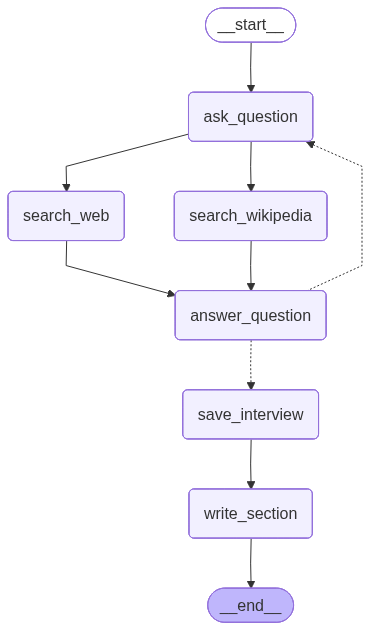

In [16]:
# graph
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [17]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Google AI Research', name='Dr. Anya Sharma', role='AI Research Scientist', description="Focuses on the breadth and depth of Python's AI/ML libraries and frameworks (e.g., TensorFlow, PyTorch, Scikit-learn, NumPy, Pandas), evaluating their capabilities, performance, and how they empower complex AI model development and scientific computing.")

In [18]:
from IPython.display import Markdown

messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

2025-09-13 14:00:20,257 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): api.tavily.com:443
2025-09-13 14:00:20,432 - urllib3.connectionpool - DEBUG - Starting new HTTP connection (1): en.wikipedia.org:80
2025-09-13 14:00:20,553 - urllib3.connectionpool - DEBUG - http://en.wikipedia.org:80 "GET /w/api.php?list=search&srprop=&srlimit=2&limit=2&srsearch=Python%27s+overlooked+advantages+and+common+misconceptions+in+AI+development+beyond+ease+of+learning+and+community+support&format=json&action=query HTTP/1.1" 301 0
2025-09-13 14:00:20,554 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): en.wikipedia.org:443
2025-09-13 14:00:21,008 - urllib3.connectionpool - DEBUG - https://en.wikipedia.org:443 "GET /w/api.php?list=search&srprop=&srlimit=2&limit=2&srsearch=Python%27s+overlooked+advantages+and+common+misconceptions+in+AI+development+beyond+ease+of+learning+and+community+support&format=json&action=query HTTP/1.1" 200 128
2025-09-13 14:00:22,297 - url

## Python's AI/ML Arsenal: Capabilities, Performance, and Model Development

### Summary
Artificial Intelligence continues to be a transformative force across industries, yet a significant misconception persists that AI will completely displace all human jobs by 2025, a notion that is not supported as many roles will continue to require human input [1]. Within this evolving technological landscape, Python has firmly established itself as the premier programming language for AI and Machine Learning development [3].

Python's widespread adoption is largely attributed to its high-level, dynamically typed nature, which promotes rapid and robust development across a broad spectrum of applications, from web and mobile development to intricate AI programs and even video games [2]. A particularly insightful aspect of Python's efficacy is its role as a "glue language" [4, 6]. This means that while Python provides a simple and intuitive interface for developers, the computationally intensive, performance-critical operations are discreetly executed by highly optimized lower-level languages such as C, C++, or CUDA [4, 6]. This architectural design allows developers to harness powerful computational capabilities without needing to engage in complex low-level programming.

The language's extensive ecosystem of deep learning libraries, including prominent frameworks like TensorFlow, Keras, and PyTorch, significantly streamlines the process of building complex AI models with minimal effort [5]. Furthermore, Python's low entry barrier makes it accessible, enabling a greater number of data scientists to quickly adopt it for AI development and fostering innovation [3]. Its platform independence also enhances its versatility [3]. The utility of Python is further augmented by the emergence of AI-assisted coding tools, often built upon Python itself, which integrate natural language processing to boost developer productivity [2]. While Python may not be the optimal choice for every single project, its capabilities make it an exceptionally strong and often preferred option for a vast array of AI and ML applications [2].

### Sources
[1] https://www.quora.com/What-s-the-biggest-misconception-people-have-about-AI-in-2025  
[2] https://www.netguru.com/blog/python-pros-and-cons  
[3] https://djangostars.com/blog/why-python-is-good-for-artificial-intelligence-and-machine-learning/  
[4] https://ai.plainenglish.io/why-python-is-still-the-best-language-for-ai-experiments-63a3de3fa9f3  
[5] https://durapid.com/why-python-is-best-for-ai-ml/  
[6] https://news.ycombinator.com/item?id=29171319